In [2]:
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from collections import namedtuple, deque
from itertools import count
from IPython.display import clear_output
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

is_ipython = 'inline' in matplotlib.get_backend()

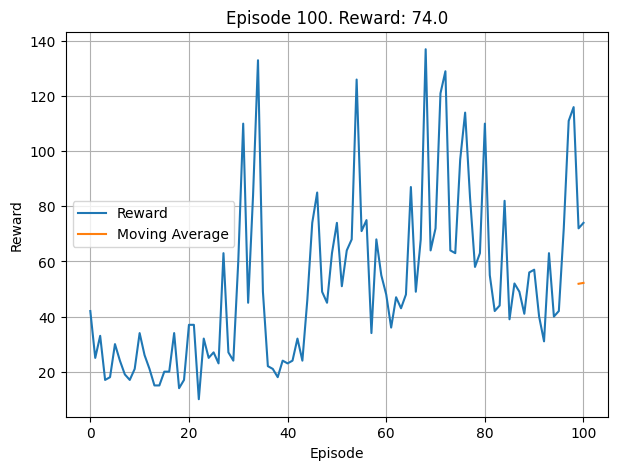

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorCritic(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(ActorCritic, self).__init__()

        # Actor network
        self.actor = nn.Sequential(
            nn.Linear(n_observations, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
            nn.Softmax(dim=-1),
        )

        # Critic network
        self.critic = nn.Sequential(
            nn.Linear(n_observations, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        state_value = self.critic(state)

        return action_probs, state_value

env = gym.make("CartPole-v1")
n_observations = env.observation_space.shape[0]
n_actions = env.action_space.n

model = ActorCritic(n_observations, n_actions).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Parameters
num_episodes = 200
gamma = 0.99
entropy_beta = 0.01

# For results plotting
rewards_per_episode = []

# Create a figure for plotting
fig, ax = plt.subplots()
plt.ion()  # Turn on interactive mode

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    
    for label,data in data_dict.items():
        if label == 'Reward':  
            # Compute moving average for Reward
            data_dict['Moving Average'] = pd.Series(data).rolling(window=100).mean().tolist()
        plt.plot(data, label=label)
        
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()
    
state_dim1_actions_0 = []
state_dim2_actions_0 = []
state_dim3_actions_0 = []
state_dim4_actions_0 = []
state_dim1_actions_1 = []
state_dim2_actions_1 = []
state_dim3_actions_1 = []
state_dim4_actions_1 = []

# Additional lists for the last episode
last_state_dim1_actions_0 = []
last_state_dim2_actions_0 = []
last_state_dim3_actions_0 = []
last_state_dim4_actions_0 = []
last_state_dim1_actions_1 = []
last_state_dim2_actions_1 = []
last_state_dim3_actions_1 = []
last_state_dim4_actions_1 = []

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0

    for step in range(5000):
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample().item()
        dim1, dim2, dim3, dim4 = state
        if action == 0:
            state_dim1_actions_0.append(dim1)
            state_dim2_actions_0.append(dim2)
            state_dim3_actions_0.append(dim3)
            state_dim4_actions_0.append(dim4)
            if episode == num_episodes - 1:  # last episode
                last_state_dim1_actions_0.append(dim1)
                last_state_dim2_actions_0.append(dim2)
                last_state_dim3_actions_0.append(dim3)
                last_state_dim4_actions_0.append(dim4)
        elif action == 1:
            state_dim1_actions_1.append(dim1)
            state_dim2_actions_1.append(dim2)
            state_dim3_actions_1.append(dim3)
            state_dim4_actions_1.append(dim4)
            if episode == num_episodes - 1:  # last episode
                last_state_dim1_actions_1.append(dim1)
                last_state_dim2_actions_1.append(dim2)
                last_state_dim3_actions_1.append(dim3)
                last_state_dim4_actions_1.append(dim4)

        next_state, reward, done, _, _ = env.step(action)
        episode_reward += reward
        log_prob = torch.log(probs.squeeze(0)[action])
        entropy = -(probs * torch.log(probs)).sum()

        # Compute advantage and actor-critic loss
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        _, next_value = model(next_state_tensor)
        td_error = reward + gamma * next_value * (1 - int(done)) - value
        actor_loss = -(log_prob * td_error.detach() + entropy_beta * entropy)
        critic_loss = td_error.pow(2)
        ac_loss = actor_loss + critic_loss

        # Optimize the model
        optimizer.zero_grad()
        ac_loss.backward()
        optimizer.step()

        if done:
            break

        state = next_state
    rewards_per_episode.append(episode_reward)

    # Update the plot
    if episode % 100 == 0:
        live_plot({'Reward': rewards_per_episode, 'Moving Average': pd.Series(rewards_per_episode).rolling(window=100).mean()},
                  title='Episode %s. Reward: %s' % (episode, rewards_per_episode[-1]))

env.close()


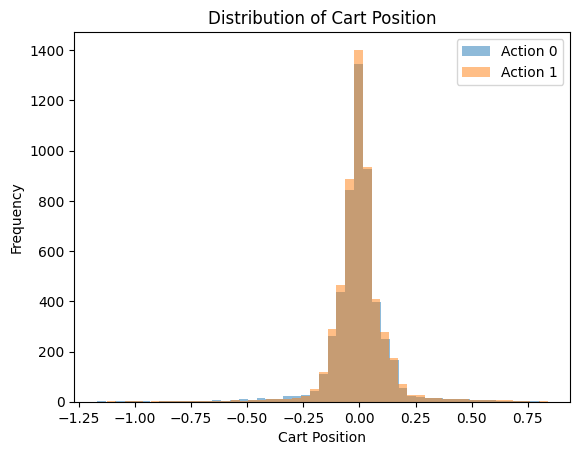

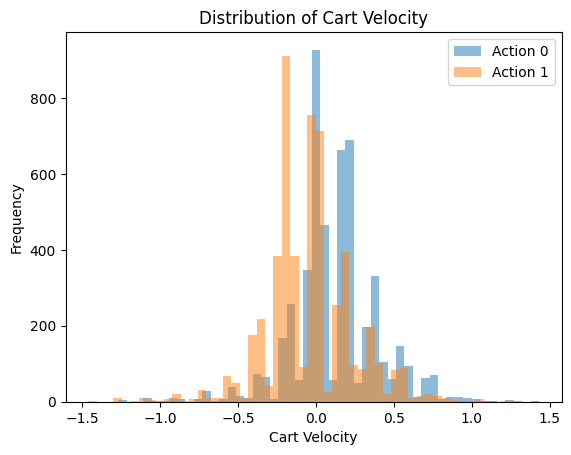

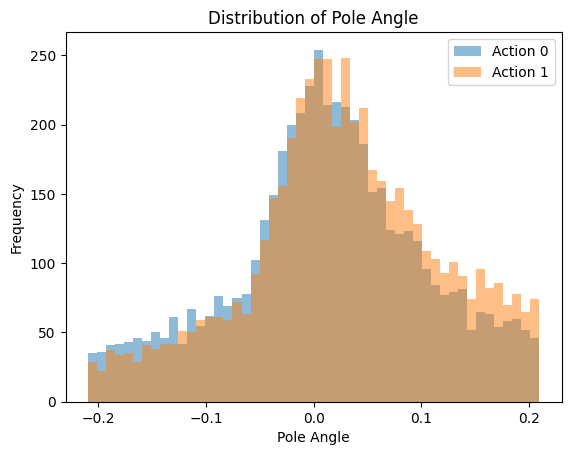

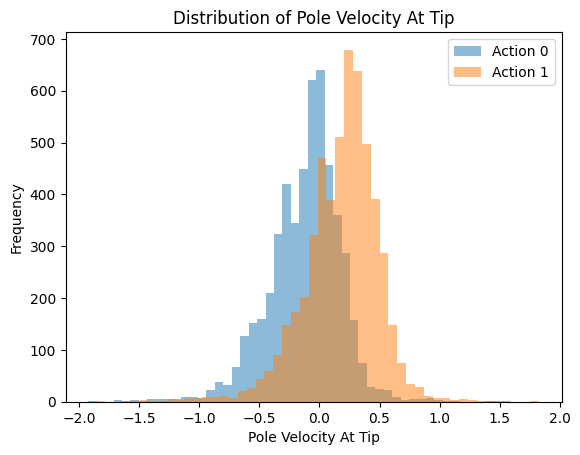

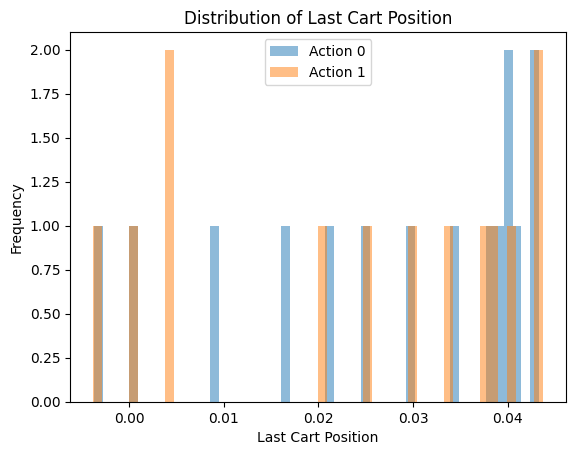

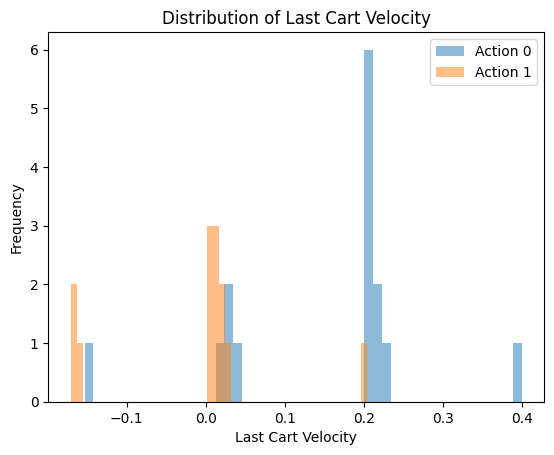

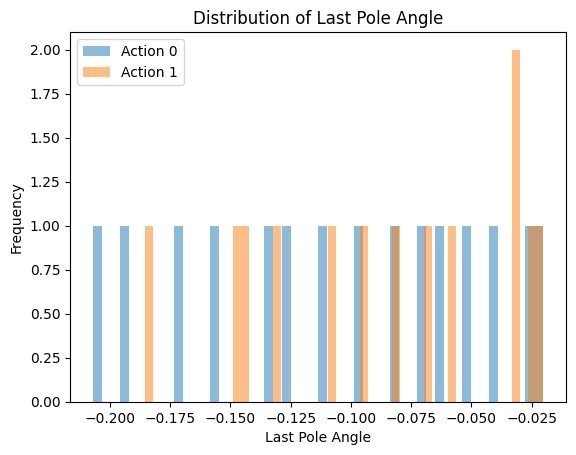

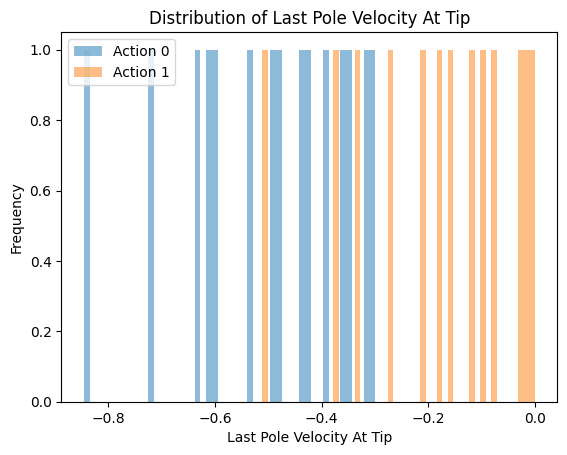

In [4]:
state_labels = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Velocity At Tip']

for i, (actions_0, actions_1, label) in enumerate(zip(
    [state_dim1_actions_0, state_dim2_actions_0, state_dim3_actions_0, state_dim4_actions_0],
    [state_dim1_actions_1, state_dim2_actions_1, state_dim3_actions_1, state_dim4_actions_1],
    state_labels
)):
    plt.figure()
    plt.hist(actions_0, bins=50, alpha=0.5, label='Action 0')
    plt.hist(actions_1, bins=50, alpha=0.5, label='Action 1')
    plt.title(f'Distribution of {label}')
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

last_state_labels = ['Last Cart Position', 'Last Cart Velocity', 'Last Pole Angle', 'Last Pole Velocity At Tip']

for i, (actions_0, actions_1, label) in enumerate(zip(
    [last_state_dim1_actions_0, last_state_dim2_actions_0, last_state_dim3_actions_0, last_state_dim4_actions_0],
    [last_state_dim1_actions_1, last_state_dim2_actions_1, last_state_dim3_actions_1, last_state_dim4_actions_1],
    last_state_labels
)):
    plt.figure()
    plt.hist(actions_0, bins=50, alpha=0.5, label='Action 0')
    plt.hist(actions_1, bins=50, alpha=0.5, label='Action 1')
    plt.title(f'Distribution of {label}')
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
